# Hard spheres model development


First stage: Develop a CNN - based GAN to work with ordered point clouds.

## Imports

In [11]:
%reload_ext autoreload
%autoreload 2

In [12]:
# Basic
from IPython.display import display

# For OS-agnostic paths
from pathlib import Path

# Plotting
from matplotlib import pyplot as plt
import seaborn as sns
import torch
from torch import nn
import pandas as pd
import numpy as np
sns.set_style("whitegrid")
from copy import deepcopy
import glob, json
from datetime import datetime
import torch
from torch import nn

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import DataLoader, Dataset, TensorDataset


from torchinfo import summary

import mlflow

%cd ..

from src.utils import load_raw_data
from src.plotting import plot_pointcloud, plot_sample_figures
from src.models.HardSphereGAN import GAN
from src.models.StaticScaler import StaticMinMaxScaler

%cd -

plt.set_cmap("viridis")

/Users/veikko/Documents/GitHub/hard-spheres
/Users/veikko/Documents/GitHub/hard-spheres/Notebooks


<Figure size 640x480 with 0 Axes>

In [13]:
import os

os.environ["MLFLOW_ENABLE_SYSTEM_METRICS_LOGGING"] = "true"

## Load data

In [14]:
phis = [0.86] # Add more phis here

path = Path("../data/raw/samples")

files, dataframe, metadata = load_raw_data(path, phi=phis)

dataframe

Number of Files found :  526


class          x          y         r
experiment sample                                           
phi-0.86   sample-245      1 -21.345870 -15.024694  0.730000
           sample-245      2  20.038204 -19.199467  0.776842
           sample-245      3 -19.955206 -14.443004  0.823684
           sample-245      6 -13.669206 -10.131996  0.964211
           sample-245      4  -9.936614  -7.810038  0.870526
...                      ...        ...        ...       ...
           sample-468      2  15.738703 -21.721624  0.776842
           sample-468      3 -19.316748 -18.640416  0.823684
           sample-468     10  21.513569 -16.596960  1.151579
           sample-468      4 -17.922827 -19.644332  0.870526
           sample-468      6 -20.417054 -13.410191  0.964211

[1052000 rows x 4 columns]

In [16]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# scaler = MinMaxScaler(feature_range=(0, 1))

scaler = StaticMinMaxScaler(
    columns = ["x", "y", "r"],
    maximum = [22, 22, 22], # NOTE: Tuned for physical feasibility
    minimum = [-22, -22, -22] # NOTE: Tuned for physical feasibility
    # maximum = [21.74652425, 21.74652425, 1.62], # NOTE: Normal minmax
    # minimum = [-21.74652425, -21.74652425, 0.73]  # NOTE: Normal minmax
    # NOTE: Scale r with the higher x,y min,max -> Ensures everything is between 0,1 but also retains physical setup with linear scaling
)

dataframe_scaled = pd.DataFrame(scaler.transform(dataframe), columns=dataframe.columns)

dataframe_scaled.set_index(dataframe.index, inplace=True)

dataframe_scaled = dataframe_scaled.drop(columns=["class"]) # Redundant with r
# dataframe_scaled = dataframe_scaled.sort_values(by=["experiment", "sample"])
dataframe_scaled.describe().round(2)

,x,y,r
count,1052000.00,1052000.00,1052000.00
mean,0.50,0.50,0.52
std,0.29,0.29,0.01
min,0.01,0.01,0.52
25%,0.25,0.25,0.52
50%,0.50,0.50,0.52
75%,0.75,0.75,0.53
max,0.99,0.99,0.54


### Attempt: Order dataframe based on Xy coordinates

This is done to introduce the spatial relationship that a CNN can utilize.


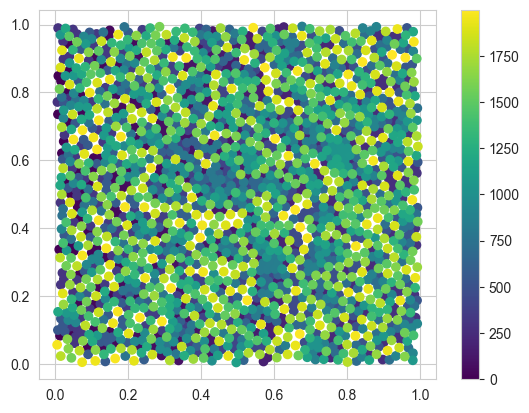

In [17]:
_X = dataframe_scaled.copy()


_X["Xy"] = np.sqrt(((_X["x"]-0.5)**2) + ((_X["y"]-0.5)**2))
_X["Xy"] = _X["r"]# + _X["y"] # Think about starting from center and going radially outwards
# _X["Xy"] = _X["r"] # Think about starting from center and going radially outwards

_X = _X.query("experiment=='phi-0.86'&sample=='sample-1'")

_X = _X.sort_values(by=["r", "x", "y"])

_X = _X.reset_index(drop=True)

_X

plt.scatter(x=_X.values[:,0], y=_X.values[:,1], c=_X.index)

plt.colorbar()

This is better than not ordered, but can be problematic as values in the middle have a high probability of ending up with non-neighbouring samples.

However it is also a good experiment as if we observe that the corners behave better than the middle, we know we are on to something.

In [23]:
dataframe_scaled_ordered = dataframe_scaled.copy()
dataframe_scaled_ordered = dataframe_scaled_ordered.sort_values(by=["experiment", "sample", "r"])
dataframe_scaled_ordered

x         y         r
experiment sample                                 
phi-0.86   sample-1   0.063381  0.181152  0.516591
           sample-1   0.067027  0.264312  0.516591
           sample-1   0.042969  0.501985  0.516591
           sample-1   0.457638  0.576509  0.516591
           sample-1   0.986067  0.579203  0.516591
...                        ...       ...       ...
           sample-99  0.413415  0.915327  0.536818
           sample-99  0.754866  0.728814  0.536818
           sample-99  0.257066  0.870888  0.536818
           sample-99  0.824746  0.257858  0.536818
           sample-99  0.930153  0.589395  0.536818

[1052000 rows x 3 columns]

## Build dataset

Creating Dataset
Descriptor List:  ['phi', 'r']
torch.Size([526, 1, 1])
torch.Size([526, 2000, 3])


<Axes: >

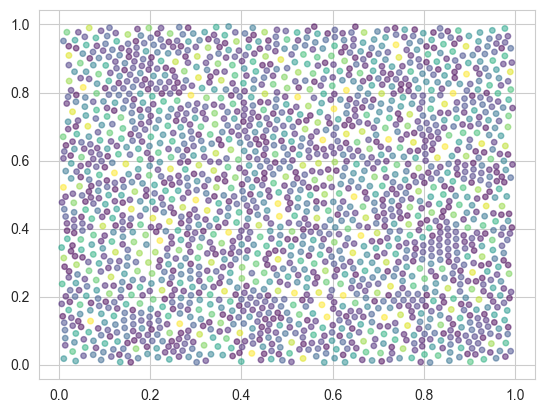

In [24]:
from src.HSDataset import HSDataset

dataset = HSDataset(
    dataframe_scaled_ordered.copy(), # Dont use the ordering
    descriptor_list=["phi", "r"],
    synthetic_samples={
        "rotational": 0,
        "shuffling": 0,
        "spatial_offset_static": 0,
        "spatial_offset_repeats": 0
        }, 
    downsample=0
    )
print(dataset[:][0].shape)
print(dataset[:][1].shape)
# Create a function that visualizes the point cloud

plot_pointcloud(dataset[2][1], plot_radius=True)

<Axes: >

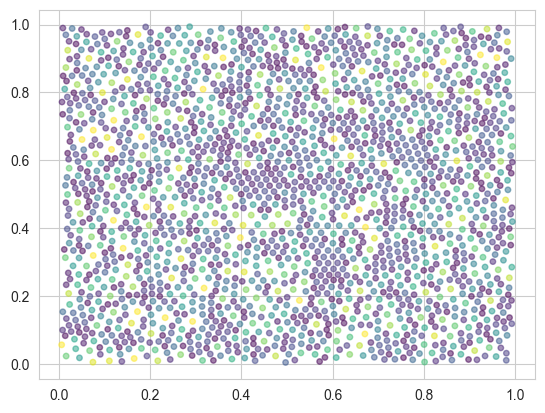

In [25]:
plot_pointcloud(dataset[0][1], plot_radius=True)


Text(0.5, 1.0, 'Mean Point Cloud, n=2000')

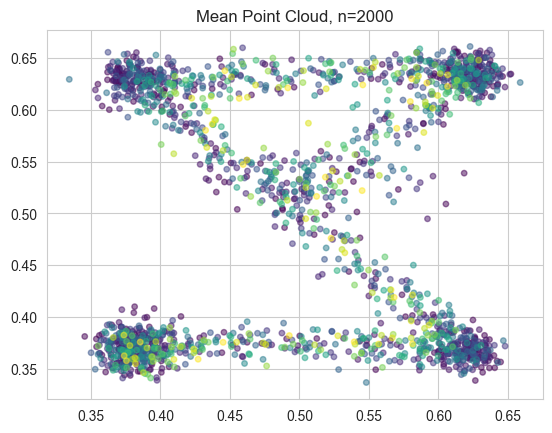

In [26]:
plot_pointcloud(dataset[:][1][:,:,:].mean(dim=0), plot_radius=True)

plt.title("Mean Point Cloud, n={}".format(len(dataset[:][1][0])))

## Note: Samples are order invariant in the sample size dimension

<Axes: >

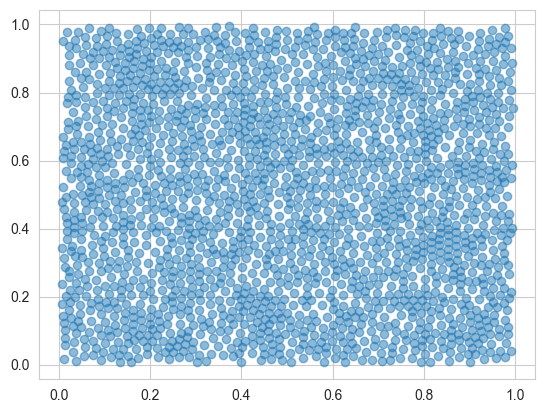

In [18]:
plot_pointcloud(reversed(dataset[2][1]), plot_radius=False)

# Create model

Create a GAN architecture, which creates point clouds $\hat{y}$ based on the descriptor(s) $\hat{X}$ and a random noise vector $\hat{z}$.

In [21]:
sample_x = dataset[0:32][0].cpu()#.transpose(-1,-2)
sample_y = dataset[0:32][1].cpu()

sample_x_mps = sample_x.to("mps")
sample_y_mps = sample_y.to("mps")

print(sample_x.shape, sample_y.shape)


torch.Size([32, 1, 1]) torch.Size([32, 2000, 3])


torch.Size([32, 1, 1])
torch.Size([32, 2000, 3])
Layer (type:depth-idx)                   Output Shape              Param #
CCCGenerator                             [32, 2000, 3]             --
├─Sequential: 1-1                        [32, 2000, 3]             --
│    └─Linear: 2-1                       [32, 60000]               120,060,000
│    └─ReLU: 2-2                         [32, 60000]               --
│    └─Unflatten: 2-3                    [32, 30, 2000, 1]         --
│    └─ConvTranspose2d: 2-4              [32, 128, 2000, 3]        11,648
│    └─BatchNorm2d: 2-5                  [32, 128, 2000, 3]        256
│    └─ReLU: 2-6                         [32, 128, 2000, 3]        --
│    └─ConvTranspose2d: 2-7              [32, 64, 2000, 3]         8,256
│    └─BatchNorm2d: 2-8                  [32, 64, 2000, 3]         128
│    └─ReLU: 2-9                         [32, 64, 2000, 3]         --
│    └─ConvTranspose2d: 2-10             [32, 32, 2000, 3]         2,080
│    └─BatchNor

<Axes: >

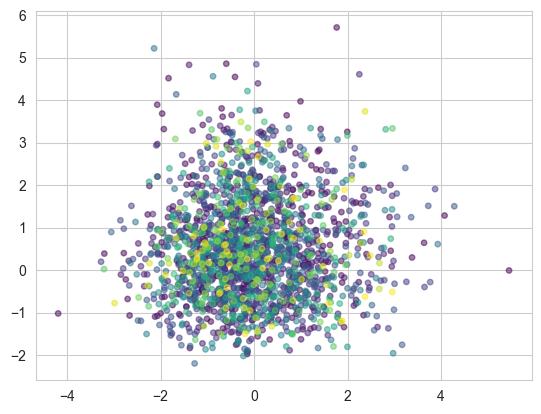

In [20]:
# Make a generator model as described in the paper
# paper: https://arxiv.org/pdf/2404.06734

in_features = 64
kernel_size = (3,3) # if 3x3, the output x,y,r will correlate with each other
stride = (1,1)

from src.models.CryinGAN import Generator, CCCGenerator

out_samples = dataset.samples[0].shape[1]

out_dimensions = 3 

generator_model_2 = CCCGenerator(
    kernel_size=1,
    stride=1,
    rand_features=out_samples,
    out_dimensions=out_dimensions,
    latent_dim=30,
    out_samples=out_samples,
    fix_r=sample_y_mps[0,:,2]
    ).to("mps")

# sample_x = sample_x.to("mps")
print(sample_x.shape)
_out = generator_model_2(sample_x_mps).detach()
print(_out.shape)

# softmaxed_r = generator_model_2._softmax_radius_dimensions(_out)
_out_torch = _out
_out = _out.cpu().numpy()

print(summary(generator_model_2, input_data=sample_x, depth=2))


plot_pointcloud(_out[0,:,:3], plot_radius=True)
# plt.xlim(0,1)
# plt.ylim(0,1)

In [27]:
import torch
import torch.nn as nn
from src.models.CryinGAN import Discriminator2D, CCCGDiscriminator

# Initialize the discriminator
input_channels = sample_y.shape[-1] # For fractional coordinates
in_samples = sample_y.shape[1] # For fractional coordinates
discriminator_model_2 = CCCGDiscriminator(input_channels=input_channels, in_samples=in_samples).to("mps")

# Print the discriminator architecture

# Example input with batch size of 16 and 3 input channels (for fractional coordinates)
batch_size = 32
# Generate output

_sample_y = sample_y.to("mps")

print(_sample_y.shape)
output = discriminator_model_2(_sample_y)
print(output.shape)

summary(discriminator_model_2, input_data=_sample_y, depth=2)

torch.Size([32, 2000, 3])
torch.Size([32, 1])


Layer (type:depth-idx)                   Output Shape              Param #
CCCGDiscriminator                        [32, 1]                   --
├─Sequential: 1-1                        [32, 256]                 --
│    └─Conv2d: 2-1                       [32, 64, 2000, 1]         256
│    └─LeakyReLU: 2-2                    [32, 64, 2000, 1]         --
│    └─Conv2d: 2-3                       [32, 128, 2000, 1]        8,320
│    └─LeakyReLU: 2-4                    [32, 128, 2000, 1]        --
│    └─Conv2d: 2-5                       [32, 256, 2000, 1]        33,024
│    └─LeakyReLU: 2-6                    [32, 256, 2000, 1]        --
│    └─AdaptiveAvgPool2d: 2-7            [32, 256, 1, 1]           --
│    └─Flatten: 2-8                      [32, 256]                 --
├─Sequential: 1-2                        [32, 1]                   --
│    └─Linear: 2-9                       [32, 1024]                263,168
│    └─LeakyReLU: 2-10                   [32, 1024]                --
│ 

## Train the model

In [48]:
(np.isclose(dataframe_scaled_ordered["r"], 0.534689)).mean()
dataframe_scaled_ordered["r"].value_counts()

r
0.516591    155170
0.517656    128870
0.518720    108356
0.519785     91524
0.520849     78374
0.521914     67328
0.522978     58386
0.524043     51022
0.525108     44710
0.526172     39450
0.527237     35242
0.528301     31560
0.529366     27878
0.530431     25248
0.531495     22618
0.532560     20514
0.533624     18936
0.534689     16832
0.535754     15254
0.536818     14728
Name: count, dtype: int64

Creating Dataset
Descriptor List:  ['phi']
torch.Size([2104, 128, 3])


Text(0.5, 1.0, 'Point Cloud, n=128')

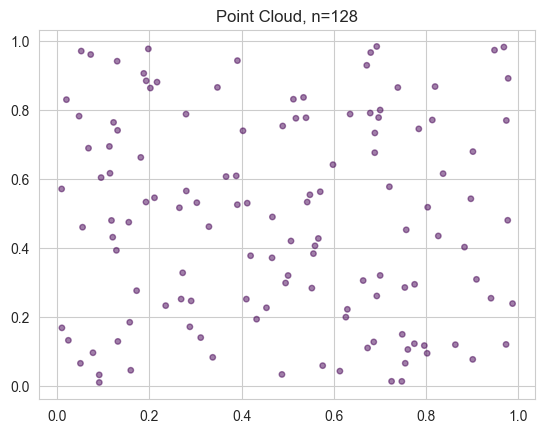

In [80]:
run_params = {
    "comment": "Fixed radius to a real sample",
    "training":{
        "device": "mps" if torch.backends.mps.is_available() else "cpu", # MPS is not supported by PyTorch 2D TransposeConv
        "batch_size": 32,
        "epochs": 5000,
        "early_stopping_patience": 20,
        "early_stopping_headstart": 0,
        "early_stopping_tolerance": 1e-3, # Gradient norm based
        "log_image_frequency": 3,
        "generator_headstart": 0,
        "training_ratio_dg": 3,
        "optimizer_g": {
            "name": "Adam",
            "lr": 0.001, # 0.00005, #0.002,  # 0.001
            # "hypergrad_lr": 1e-6,
            "weight_decay": 0,
            "betas": (0.5, 0.999)
        },
        "optimizer_d": {
            "name": "Adam",
            "lr": 0.001, #0.002, 
            # "hypergrad_lr": 1e-6,
            "weight_decay": 0,
            "betas": (0.5, 0.999)
        },
        "d_loss":{
            "name": "CryinGANDiscriminatorLoss", # CryinGANDiscriminatorLoss for WaGAN + L1 loss, BCELoss for baseline
            "mu": 0.5, # L1 loss coefficient
        },
        "g_loss":{
            "name": "HSGeneratorLoss",
            "radius_loss": 0,
            "grid_density_loss": 0,
            "gan_loss": 1,
            "distance_loss": 0,
            "physical_feasibility_loss": 0,
            "coefficients":{
                "gan_loss": 10,
                "radius_loss": 0,
                "grid_density_loss": 1,
                "physical_feasibility_loss": 10,
                "distance_loss": 10,
            },
        }
    },
    "dataset":{
        "descriptor_list": ["phi"],
        "synthetic_samples":{
            "rotational": 0,
            "shuffling": 0,
            "spatial_offset_static": 0.05,
            "spatial_offset_repeats": 2
            }, # NOTE: Could do subsquares and more rotations.
        "downsample": 0,
    },

}

dataframe_scaled_ordered_filtered = dataframe_scaled_ordered[np.isclose(dataframe_scaled_ordered["r"], 0.521914)]

dataset = HSDataset(
    dataframe_scaled_ordered_filtered.copy(), # NOTE: Ordered -> ordered by radius.
    **run_params["dataset"]
    )
print(dataset.y.shape)

plot_pointcloud(dataset[:][1][4], plot_radius=True)

plt.title("Point Cloud, n={}".format(len(dataset[:][1][0])))

1684 420
Layer (type:depth-idx)                   Output Shape              Param #
CCCGenerator                             [32, 128, 3]              --
├─Sequential: 1-1                        [32, 128, 3]              --
│    └─Linear: 2-1                       [32, 16384]               8,421,376
│    └─ReLU: 2-2                         [32, 16384]               --
│    └─Unflatten: 2-3                    [32, 128, 128, 1]         --
│    └─ConvTranspose2d: 2-4              [32, 128, 128, 3]         49,280
│    └─BatchNorm2d: 2-5                  [32, 128, 128, 3]         256
│    └─ReLU: 2-6                         [32, 128, 128, 3]         --
│    └─ConvTranspose2d: 2-7              [32, 64, 128, 3]          8,256
│    └─BatchNorm2d: 2-8                  [32, 64, 128, 3]          128
│    └─ReLU: 2-9                         [32, 64, 128, 3]          --
│    └─ConvTranspose2d: 2-10             [32, 32, 128, 3]          2,080
│    └─BatchNorm2d: 2-11                 [32, 32, 128, 3]

10603201

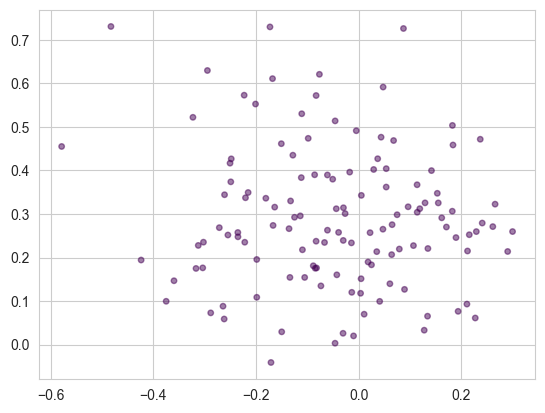

In [81]:
from src.models.CryinGAN import CCCGDiscriminator, CCCGeneratorWithDiffusion, CCCGenerator

test_frac = 0.2
kernel_size = (3,3)
dataset = dataset.to(run_params["training"]["device"])

dataset = dataset.to(run_params["training"]["device"])
trainset, testset = torch.utils.data.random_split(dataset, [1-test_frac, test_frac])
print(len(trainset), len(testset))

sample_x = dataset[0:32][0].cpu()#.transpose(-1,-2)
sample_y = dataset[0:32][1].cpu()

sample_x_mps = sample_x.to("mps")
sample_y_mps = sample_y.to("mps")

out_samples = dataset.samples[0].shape[1]
out_dimensions = dataset.samples[0].shape[2]

kernel_size = (1,1)
stride=1


generator = CCCGenerator(
    kernel_size=kernel_size,
    stride=stride,
    channels_coefficient=1,
    rand_features=513,# 513 for one paper, 64 for another,
    out_dimensions=out_dimensions,
    out_samples=out_samples,
    latent_dim=128, # 128 for the papers
    fix_r=sample_y_mps[0,:,2],
    clip_output = False
    # (
    #     dataset.y.min(dim=0).values.min(dim=0).values,
    #     dataset.y.max(dim=0).values.max(dim=0).values
    # )
    ).to("mps")

input_channels = 3

discriminator = CCCGDiscriminator(
    input_channels=input_channels, 
    in_samples=out_samples, 
    kernel_size=(1,1),
    channels_coefficient=1
    ).to("mps")

gan = GAN(
    dataset, 
    dataset,# No separate test set
    generator_model=generator,
    discriminator_model=discriminator,
    **run_params
    )

print(summary(gan.generator, input_data=sample_x_mps, depth=2))
print(summary(gan.discriminator, input_data=sample_y_mps, depth=2))

_out = gan.generate(sample_x)[0]

plot_pointcloud(_out, plot_radius=True)
# plt.xlim(0,1)
# plt.ylim(0,1)
10_603_201


In [82]:
sample_size = out_samples

# run 'mlflow server --host 127.0.0.1 --port 8080' before starting training

gan.train_n_epochs(
    epochs=run_params["training"]["epochs"],
    batch_size=run_params["training"]["batch_size"],
    experiment_name=f"Fullscale, subsampled r, sample size = {sample_size}",
    requirements_file = Path("../top-level-requirements.txt"),
    save_model=True
)

2024/12/27 11:32:42 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/12/27 11:32:42 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Using requirements file: /Users/veikko/Documents/GitHub/hard-spheres/top-level-requirements.txt
Starting run mountain-car-040b7a3d-3ce3-4495-a220-05e799c69713...
Time: 2024-12-27 11:32:42


  9%|▊         | 435/5000 [44:56<2:55:32,  2.31s/it]  /Users/veikko/Documents/GitHub/hard-spheres/.venv/lib/python3.12/site-packages/mlflow/tracking/client.py:2161: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  figure.savefig(tmp_path, **save_kwargs)
 41%|████▏     | 2068/5000 [1:56:08<2:44:39,  3.37s/it] 

Early stopping
Logging models to mlflow



2024/12/27 13:28:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run mountain-car-040b7a3d-3ce3-4495-a220-05e799c69713 at: http://127.0.0.1:8080/#/experiments/335927330592148269/runs/f149fbd9ce1e4e7b97bfe7e0ee067280.
2024/12/27 13:28:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/335927330592148269.
2024/12/27 13:28:51 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/12/27 13:28:51 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


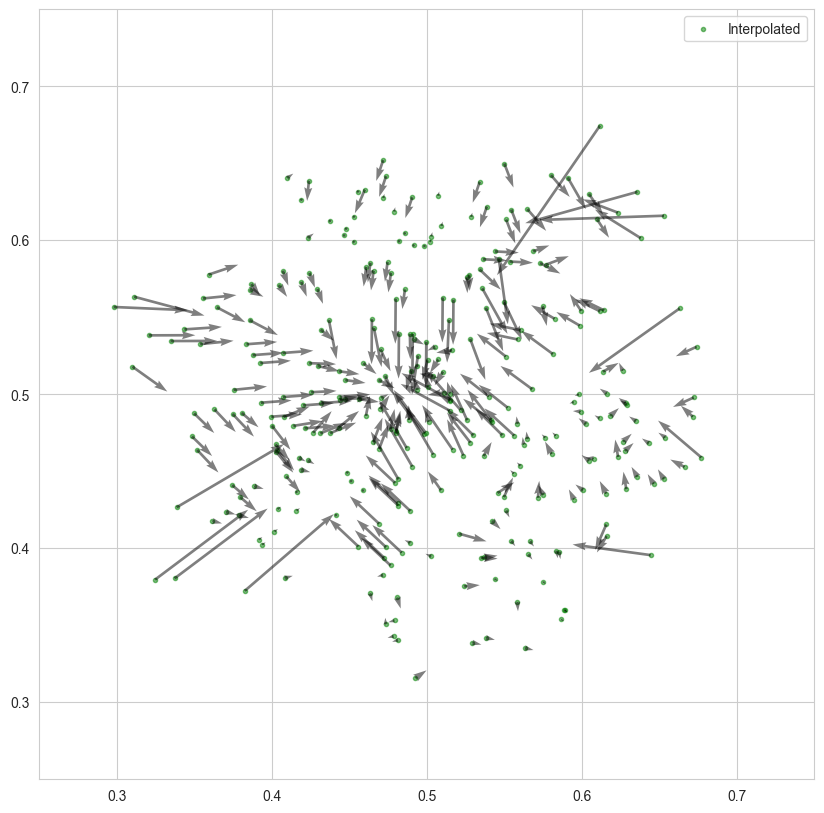

In [200]:
# Compute the gradients for plotting

real_images = sample_y_mps
fake_images = gan.generate(sample_x_mps).to(real_images.device)

alpha = torch.rand(real_images.size(0), 1, 1).to(real_images.device)
interpolates_coord = alpha * real_images + (1 - alpha) * fake_images
interpolates_coord = interpolates_coord.requires_grad_(True)
d_interpolates_coord = discriminator(interpolates_coord)

grad_outputs_coord = torch.ones_like(d_interpolates_coord)

gradients = torch.autograd.grad(
    outputs=d_interpolates_coord,
    inputs=interpolates_coord,
    grad_outputs=grad_outputs_coord,
    create_graph=True,
    retain_graph=True,
    only_inputs=True,
    is_grads_batched=False,
)[0]

# Plot the points and the related gradients
plt.figure(figsize=(10,10))
# plt.scatter(x=real_images[0,:,0].cpu(), y=real_images[0,:,1].cpu(), c="blue", alpha=0.5,marker=".", label="Real")
plt.scatter(x=interpolates_coord[0,:,0].cpu().detach(), y=interpolates_coord[0,:,1].cpu().detach(), c="green", alpha=0.5,marker=".", label="Interpolated")
# plt.scatter(x=fake_images[0,:,0].cpu(), y=fake_images[0,:,1].cpu(), c="red", alpha=0.5,marker=".",label="Fake")

plt.quiver(
    interpolates_coord[0,:,0].cpu().detach(),
    interpolates_coord[0,:,1].cpu().detach(),
    gradients[0,:,0].cpu().detach(),
    gradients[0,:,1].cpu().detach(),
    alpha=0.5,
)
plt.xlim(.25,.75)
plt.ylim(.25,.75)
plt.legend()

<Axes: >

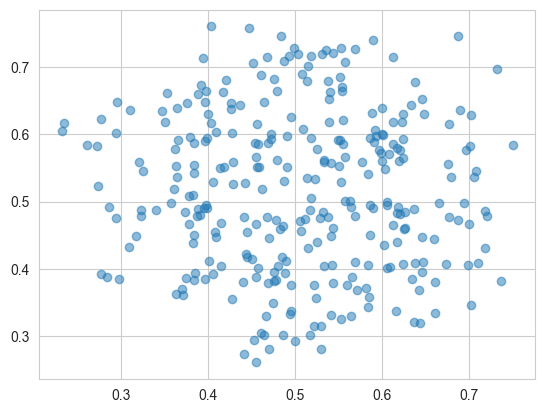

In [170]:
_out = gan.generate(sample_x)[0]
# _out = _out.numpy()

plot_pointcloud(_out, plot_radius=False)


## Test the discriminator with random data

torch.Size([32, 300, 3])
torch.Size([32, 1])
Mean of discriminator output: 0.017940286546945572


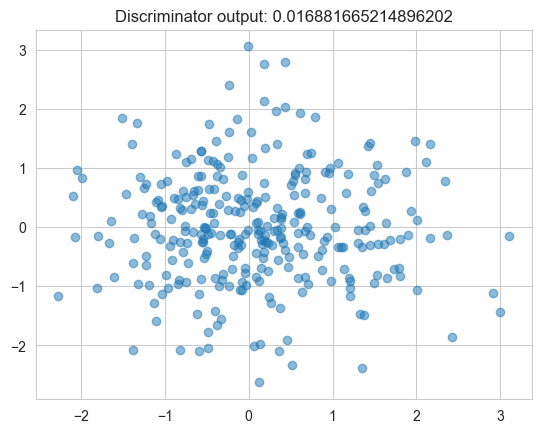

In [55]:
# Test the discriminator with random data

# Generate random data
random_data = torch.rand_like(sample_y).to("mps")
random_data = torch.randn_like(sample_y).to("mps")
print(random_data.shape)

plot_pointcloud(random_data[0].cpu().numpy(), plot_radius=False)

# Test the discriminator

output = gan.discriminator(random_data)
print(output.shape)
print("Mean of discriminator output:", output.mean().item())
plt.title(f"Discriminator output: {output[0].item()}")
plt.show()

# Profile model performance for computational bottlenecks

In [47]:
from torch.profiler import profile, record_function, ProfilerActivity

with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        gan.generator(sample_x)


In [48]:
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=20))

------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                     model_inference        12.81%     251.374us       100.00%       1.962ms       1.962ms             1  
              aten::conv_transpose2d         0.34%       6.668us        28.64%     562.042us     140.510us             4  
                   aten::convolution         1.01%      19.916us        28.30%     555.374us     138.844us             4  
                  aten::_convolution         1.15%      22.541us        27.29%     535.458us     133.865us             4  
                        aten::linear        20.71%     406.333us        20.86%     409.458us     409.458us             1  
                

In [49]:
from torch.profiler import profile, record_function, ProfilerActivity

with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        gan.discriminator(sample_y_mps)

    # print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))


In [50]:
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=20))

-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                         Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
              model_inference        17.49%     243.063us       100.00%       1.389ms       1.389ms             1  
                 aten::conv2d         0.40%       5.626us        32.63%     453.315us     151.105us             3  
            aten::convolution         1.85%      25.674us        32.22%     447.689us     149.230us             3  
           aten::_convolution         1.13%      15.754us        30.37%     422.015us     140.672us             3  
       aten::_mps_convolution        22.10%     307.112us        22.76%     316.240us     105.413us             3  
                 aten::linear        20.50%     284.898us        20.73% 

### OPEN QUESTIONS

- What to do with the metadata?
- Class and radius are redundant. Is the real physical measure numerical or categorical / quantified? 

In [46]:
metadata.round(5).drop_duplicates()

,,N,L,A
experiment,sample,,,
phi-0.86,sample-245,2000,43.49306,1626.81571


## Pointnet

In [ ]:
from pointnet.dataset import ShapeNetDataset, ModelNetDataset
from pointnet.model import PointNetCls, feature_transform_regularizer, PointNetfeat

ImportError: cannot import name 'PointNetCls2' from 'pointnet.model' (/Users/veikko/Documents/GitHub/hard-spheres/src/pointnet.pytorch/pointnet/model.py)

In [35]:
summary(PointNetfeat(), input_size=(32, 3, 1024))

Layer (type:depth-idx)                   Output Shape              Param #
PointNetfeat                             [32, 1024]                --
├─STN3d: 1-1                             [32, 3, 3]                --
│    └─Conv1d: 2-1                       [32, 64, 1024]            256
│    └─BatchNorm1d: 2-2                  [32, 64, 1024]            128
│    └─Conv1d: 2-3                       [32, 128, 1024]           8,320
│    └─BatchNorm1d: 2-4                  [32, 128, 1024]           256
│    └─Conv1d: 2-5                       [32, 1024, 1024]          132,096
│    └─BatchNorm1d: 2-6                  [32, 1024, 1024]          2,048
│    └─Linear: 2-7                       [32, 512]                 524,800
│    └─BatchNorm1d: 2-8                  [32, 512]                 1,024
│    └─Linear: 2-9                       [32, 256]                 131,328
│    └─BatchNorm1d: 2-10                 [32, 256]                 512
│    └─Linear: 2-11                      [32, 9]         